<a href="https://colab.research.google.com/github/yusufokunlola/Livestock_Emissions/blob/main/Livestock_Emissions_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- # Libraries to install

# pycountry-convert provides conversion functions between ISO country names, country-codes, and continent names.
! pip install pycountry-convert

# To install Facebook Prophet, use this command:
! pip install prophet -->

In [29]:
# Import libraries
import os
import pandas as pd
import numpy as np
import pycountry_convert as pc
import pycountry

import matplotlib
matplotlib.use('Agg')  # Use a non-interactive backend
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set display options to show full dataset
pd.set_option('display.max_rows', None)   # Show all rows
pd.set_option('display.max_columns', None) # Show all columns
pd.set_option('display.width', None)      # Do not truncate output

In [2]:
# mainpath="/content/drive"
# inpath=mainpath+"/MyDrive/Livestock_Emissions_Project"

In [3]:
# from google.colab import drive
# drive.mount(mainpath)

In [4]:
# Function to retrieve continent using ISO2 code
def country_to_continent(country_code):
    if pd.isna(country_code) or not isinstance(country_code, str):
        return "Unknown"
    try:
        country_continent_code = pc.country_alpha2_to_continent_code(country_code)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except KeyError:
        return "Unknown"


# Function to retrieve ISO3 code using ISO2 code
def iso2_to_iso3(country_code):
    if pd.isna(country_code) or not isinstance(country_code, str):
        return "Unknown"
    try:
        # Using pycountry to get the ISO3 code from ISO2
        country = pycountry.countries.get(alpha_2=country_code.upper())
        return country.alpha_3
    except AttributeError:
        return "Unknown"
    
    

# Function to save the plot
def save_plot(title, directory="visualization"):
    """
    Save a plot with a given title in the specified directory.

    Parameters:
    - title: The title of the plot, which will also be used as the filename.
    - directory: The folder where the plot should be saved (default: 'visualization').
    """
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    valid_filename = "".join([c if c.isalnum() else "_" for c in title]) + ".jpg"
    file_path = os.path.join(directory, valid_filename)
    
    plt.savefig(file_path, bbox_inches="tight", dpi=300)
    print(f"Plot saved to {file_path}")
    

# # Data wrangling function for data cleaning
# def wrangle(df):

#     # Drop columns with single values
#     df.drop(['Domain Code', 'Domain', 'Element Code', 'Element', 'Item Code (CPC)', 'Item',
#        'Year Code','Source Code', 'Source'], axis=1, inplace=True)

#     # Ensure 'Area Code (ISO2)' column contains strings
#     df['Area Code (ISO2)'] = df['Area Code (ISO2)'].astype(str)

#     # Add the Continent column
#     df['Continent'] = df['Area Code (ISO2)'].apply(country_to_continent)

#     # Define the continent mapping for specific areas without recent ISO2 codes - ISO 3166-1 alpha-2 (https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2)
#     special_cases = {
#         'China': 'Asia',
#         'Timor-Leste': 'Asia',
#         'Namibia': 'Africa',
#         'Palestine': 'Asia',
#         'Sudan (former)': 'Africa',
#         'Serbia and Montenegro': 'Europe'
#     }

#     # Apply lambda function to replace 'Unknown' with the appropriate continent
#     df['Continent'] = df.apply(
#         lambda row: special_cases.get(row['Area'], 'Unknown') if row['Continent'] == 'Unknown' else row['Continent'],
#         axis=1)

#     df = df.copy()

#     # Filter the DataFrame by dropping areas with a count less than 22
#     df = df[~df['Area'].isin(df['Area'].value_counts()[df['Area'].value_counts() < 22].index)]

#     # Drop rows where 'Area' is 'China, mainland'
#     df = df[df['Area'] != 'China, mainland']

#     # Drop ISO2 code column
#     df.drop('Area Code (ISO2)', axis=1, inplace=True)

#     # Return the cleaned DataFrame
#     return df

In [5]:
# Data wrangling function for data cleaning
def wrangle(df):

    # Check if columns exist before attempting to drop them
    columns_to_drop = ['Domain Code', 'Domain', 'Element Code', 'Element', 'Item Code (CPC)', 'Item',
                       'Year Code', 'Source Code', 'Source']

    # Drop columns only if they exist in the DataFrame
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1, errors='ignore')

    # Ensure 'Area Code (ISO2)' column exists and contains strings
    if 'Area Code (ISO2)' in df.columns:
        df['Area Code (ISO2)'] = df['Area Code (ISO2)'].astype(str)
    else:
        print("'Area Code (ISO2)' column is missing from the DataFrame.")

    # Add the Continent column if 'country_to_continent' function is available
    if 'Area Code (ISO2)' in df.columns:
        df['Continent'] = df['Area Code (ISO2)'].apply(country_to_continent)
        
    # Add the Continent column if 'country_to_continent' function is available
    if 'Area Code (ISO2)' in df.columns:
        df['Area Code (ISO3)'] = df['Area Code (ISO2)'].apply(iso2_to_iso3)

    # Define the continent mapping for specific areas without recent ISO2 codes
    special_cases = {
        'China': 'Asia',
        'Timor-Leste': 'Asia',
        'Namibia': 'Africa',
        'Palestine': 'Asia',
        'Sudan (former)': 'Africa',
        'Serbia and Montenegro': 'Europe'
    }

    # Apply lambda function to replace 'Unknown' with the appropriate continent from special cases
    if 'Continent' in df.columns and 'Area' in df.columns:
        df['Continent'] = df.apply(
            lambda row: special_cases.get(row['Area'], row['Continent']) if row['Continent'] == 'Unknown' else row['Continent'],
            axis=1
        )

    # Ensure a clean copy of the DataFrame
    df = df.copy()

    # Check if 'Area' exists before filtering
    if 'Area' in df.columns:
        # Filter the DataFrame by dropping areas with a count less than 22
        area_counts = df['Area'].value_counts()
        df = df[~df['Area'].isin(area_counts[area_counts < 22].index)]

        # Drop rows where 'Area' is 'China' because 'China' and 'China, mainland' records were same
        df = df[df['Area'] != 'China']
    else:
        print("'Area' column is missing from the DataFrame.")
           
    
    # Set Area Code (ISO2) and Country Code for Namibia and Palestine Source: https://www.iban.com/country-codes
    df.loc[df['Area'] == 'Namibia', ['Area Code (ISO2)', 'Area Code (ISO3)']] = ['NA', 'NAM']
    df.loc[df['Area'] == 'Palestine', ['Area Code (ISO2)', 'Area Code (ISO3)']] = ['PS', 'PSE']


    # Drop 'Area Code (ISO2)' column if it exists
    if 'Area Code (ISO2)' in df.columns:
        df.drop('Area Code (ISO2)', axis=1, inplace=True)

    # Return the cleaned DataFrame
    return df

In [6]:
# Load the original dataset
# data = pd.read_csv(inpath+'/datasets/Cattle_CH4_dataset_1961_2021.csv') #- (1961 - 2022)

# data = pd.read_csv(inpath+'/datasets/Cattle_CH4_dataset_2000_2021.csv') #- (2000 - 2022)

data = pd.read_csv('dataset/Cattle_CH4_dataset_2000_2021.csv')
data.head()

,Domain Code,Domain,Area Code (ISO2),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Source Code,Source,Value
0,GLE,Emissions from Livestock,AF,Afghanistan,72441,Livestock total (Emissions CH4),F1757,Cattle,2000,2000,3050,FAO TIER 1,152.100
1,GLE,Emissions from Livestock,AF,Afghanistan,72441,Livestock total (Emissions CH4),F1757,Cattle,2001,2001,3050,FAO TIER 1,119.621
2,GLE,Emissions from Livestock,AF,Afghanistan,72441,Livestock total (Emissions CH4),F1757,Cattle,2002,2002,3050,FAO TIER 1,196.135
3,GLE,Emissions from Livestock,AF,Afghanistan,72441,Livestock total (Emissions CH4),F1757,Cattle,2003,2003,3050,FAO TIER 1,199.441
4,GLE,Emissions from Livestock,AF,Afghanistan,72441,Livestock total (Emissions CH4),F1757,Cattle,2004,2004,3050,FAO TIER 1,182.926


In [7]:
# check unique features
data.nunique()

Domain Code            1
Domain                 1
Area Code (ISO2)     198
Area                 199
Element Code           1
Element                1
Item Code (CPC)        1
Item                   1
Year Code             22
Year                  22
Source Code            1
Source                 1
Value               4106
dtype: int64

In [8]:
# Apply the wrangle function built for data cleaning
df = wrangle(data)

# print
df.head()

,Area,Year,Value,Continent,Area Code (ISO3)
0,Afghanistan,2000,152.100,Asia,AFG
1,Afghanistan,2001,119.621,Asia,AFG
2,Afghanistan,2002,196.135,Asia,AFG
3,Afghanistan,2003,199.441,Asia,AFG
4,Afghanistan,2004,182.926,Asia,AFG


In [9]:
# check dataset shape
df.shape

(4224, 5)

In [10]:
df.nunique()

Area                 192
Year                  22
Value               4014
Continent              6
Area Code (ISO3)     192
dtype: int64

In [11]:
df['Continent'].unique()

array(['Asia', 'Europe', 'Africa', 'North America', 'South America',
       'Oceania'], dtype=object)

In [12]:
df.isnull().sum()

Area                0
Year                0
Value               0
Continent           0
Area Code (ISO3)    0
dtype: int64

In [13]:
# save cleaned dataset
# df.to_csv('dataset/Cattle_CH4_dataset_cleaned.csv', index=False)

## **Global Analysis**

In [14]:
# Display the number of unique countries in each continent
print(df.groupby('Continent')['Area'].nunique())

Continent
Africa           53
Asia             49
Europe           38
North America    26
Oceania          13
South America    13
Name: Area, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_23336\3437649012.py:29: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Plot saved to visualization\Number_of_Unique_Countries_in_Each_Continent.jpg


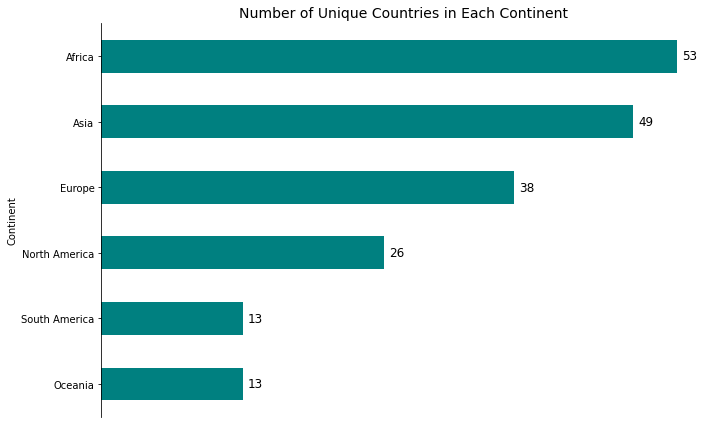

In [31]:
# @title Number of Unique Countries in Each Continent

# Group by continent and count unique areas (countries), sorted in descending order
continent_area_counts = df.groupby('Continent')['Area'].nunique().sort_values(ascending=True)

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 6))
bars = continent_area_counts.plot(kind='barh', color='teal')

# Add labels at the end of each bar
for index, value in enumerate(continent_area_counts):
    plt.text(value + 0.5, index, str(value), va='center', ha='left', fontsize=12, color='black')

# Remove the top, right, and bottom border (spines)
bars.spines['top'].set_visible(False)
bars.spines['right'].set_visible(False)
bars.spines['bottom'].set_visible(False)

# Remove the x-axis ticks
plt.xticks([])

# Add titles and labels
title = 'Number of Unique Countries in Each Continent'
plt.title(title, fontsize=14)
plt.ylabel('Continent')

# Display the plot
plt.tight_layout()
plt.show()

# Save the plot
save_plot(title)

Plot saved to visualization\Average_Global_Methane_Emissions_from_Cattle__2000_2021_.jpg


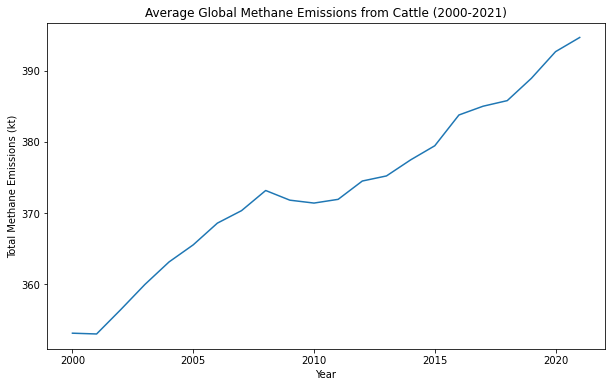

In [17]:
# @title Average Global Methane Emissions from Cattle (2000-2021)

emissions_by_year = df.groupby('Year')['Value'].mean()

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(emissions_by_year.index, emissions_by_year.values)
plt.xlabel('Year')
plt.ylabel('Total Methane Emissions (kt)')
title = 'Average Global Methane Emissions from Cattle (2000-2021)'
plt.title(title)

# Save the plot
save_plot(title)

Plot saved to visualization\Average_Methane_Emmission_from_Cattle_by_Continent__2000_2021_.jpg


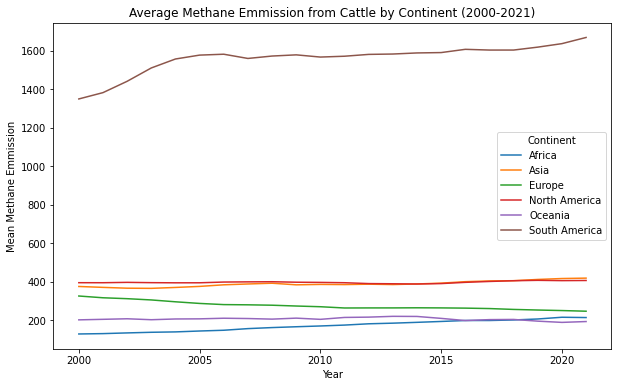

In [18]:
# @title Average Methane Emissions from Cattle by Continent (2000-2021)

# Group by Continent and Year, then calculate the mean of the 'Value' (temperature)
mean_temp_by_year_continent = df.groupby(['Year', 'Continent'])['Value'].mean().unstack()

# Plotting the mean Methane Emmission for each continent across the years
mean_temp_by_year_continent.plot(figsize=(10,6))

plt.xlabel('Year')
plt.ylabel('Mean Methane Emmission')
plt.legend(title='Continent')
title = 'Average Methane Emmission from Cattle by Continent (2000-2021)'
plt.title(title)

# Save the plot
save_plot(title)

In [48]:
#@title Average Methane Emissions from Cattle by Continent (2000-2021) - Interactive Chart

# Group the data by continent and year, and calculate the mean of the 'Value' column
emissions_by_continent_year = df.groupby(['Continent', 'Year'])['Value'].mean().reset_index()

# Create an empty figure
fig = go.Figure()

# Add a trace for each continent
continents = emissions_by_continent_year['Continent'].unique()
for continent in continents:
    continent_data = emissions_by_continent_year[emissions_by_continent_year['Continent'] == continent]
    fig.add_trace(go.Scatter(x=continent_data['Year'], y=continent_data['Value'], mode='lines+markers', name=continent, visible=False))

# Make only the first continent visible
fig.data[0].visible = True

# Create dropdown menu options
dropdown_buttons = []
for i, continent in enumerate(continents):
    dropdown_buttons.append(dict(method='update',
                                 label=continent,
                                 args=[{'visible': [j == i for j in range(len(continents))]},
                                       {'title': f'Average Methane Emissions from Cattle in {continent} (2000-2021)'}]))

# Add dropdown to the layout
fig.update_layout(
    updatemenus=[dict(active=0, buttons=dropdown_buttons, x=1.15, y=1.25)],
    title=f'Average Methane Emissions from Cattle in {continents[0]} (2000-2021)',
    xaxis_title='Year',
    yaxis_title='Total Methane Emissions (kt)',
)

# Show the figure
fig.show()

Plot saved to visualization\Average_Methane_Emissions_from_Cattle_in_Africa__2000_2021_.jpg


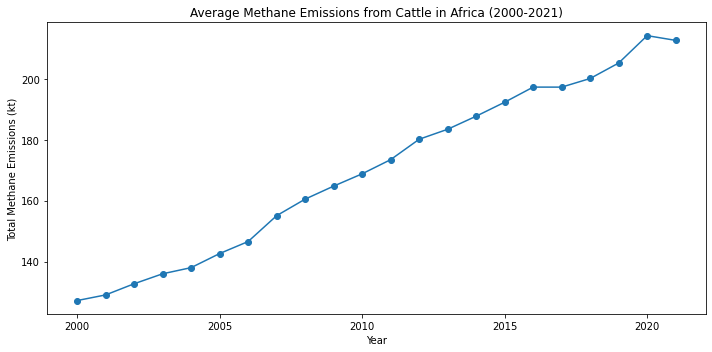

Plot saved to visualization\Average_Methane_Emissions_from_Cattle_in_Asia__2000_2021_.jpg


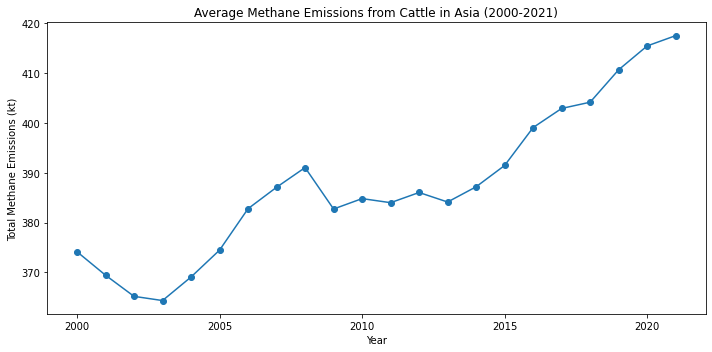

Plot saved to visualization\Average_Methane_Emissions_from_Cattle_in_Europe__2000_2021_.jpg


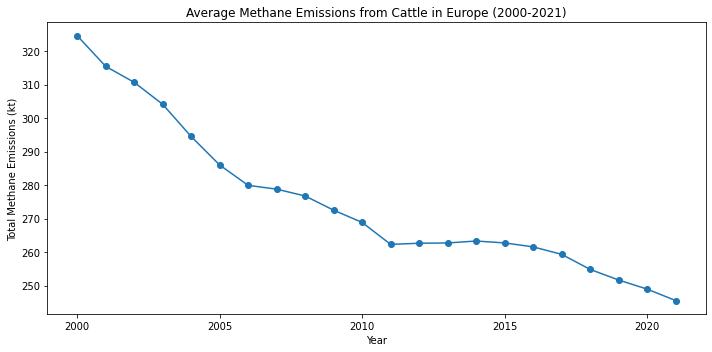

Plot saved to visualization\Average_Methane_Emissions_from_Cattle_in_North_America__2000_2021_.jpg


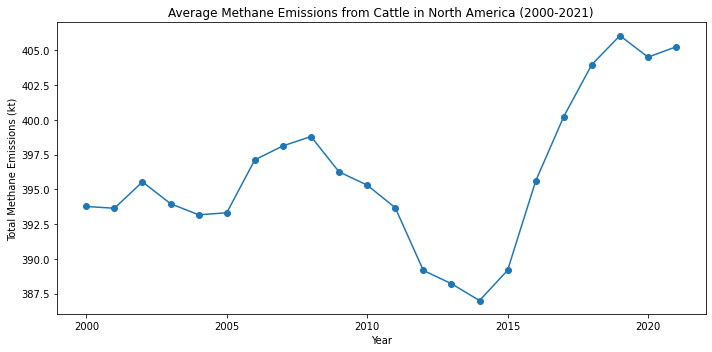

Plot saved to visualization\Average_Methane_Emissions_from_Cattle_in_Oceania__2000_2021_.jpg


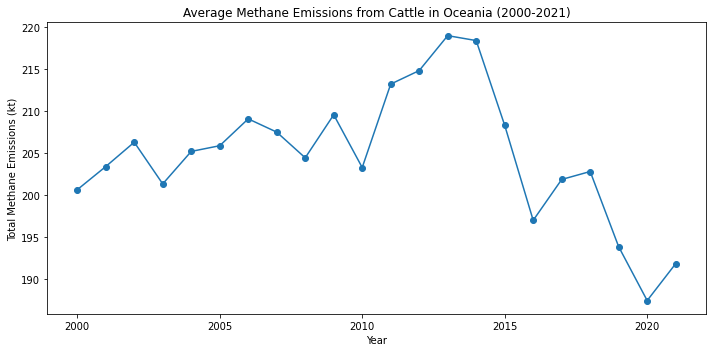

Plot saved to visualization\Average_Methane_Emissions_from_Cattle_in_South_America__2000_2021_.jpg


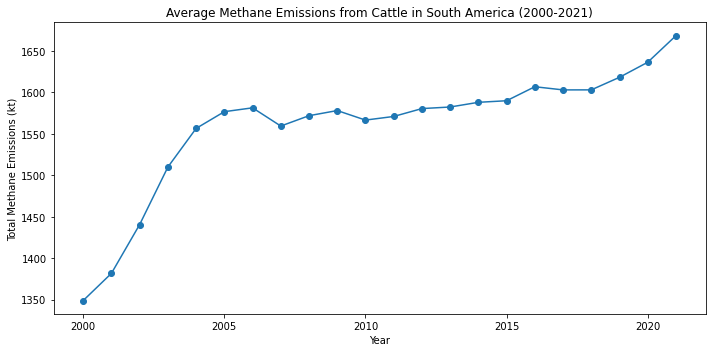

In [24]:
# @title Average Methane Emissions from Cattle by Continent (2000-2021) 
emissions_by_continent_year = df.groupby(['Continent', 'Year'])['Value'].mean().unstack('Continent')

# Create a line chart for each continent
for continent in emissions_by_continent_year.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(emissions_by_continent_year.index, emissions_by_continent_year[continent], marker='o', linestyle='-')
    plt.xlabel('Year')
    plt.ylabel('Total Methane Emissions (kt)')
    title = f'Average Methane Emissions from Cattle in {continent} (2000-2021)'
    plt.title(title)

    # Save the plot to the visualization folder
    save_plot(title)

    plt.tight_layout()
    plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_23336\2175067269.py:25: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Plot saved to visualization\Methane_Emissions_from_Cattle_in_the_Top_5_Countries_Worldwide__2000_2021_.jpg


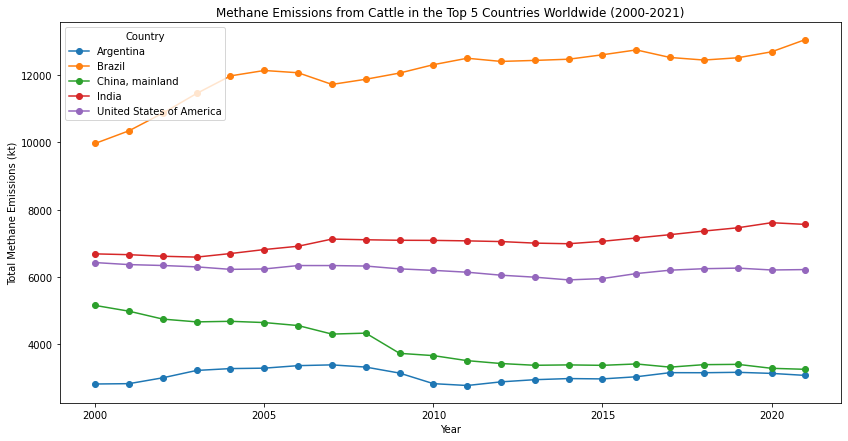

In [32]:
# @title Methane Emissions from Cattle in the Top 5 Countries Worldwide (2000-2021)

# Calculate total emissions by country
total_emissions_by_country = df.groupby('Area')['Value'].sum()

# Get the top 5 countries with the highest total emissions
top_5_countries = total_emissions_by_country.nlargest(5).index

# Filter the DataFrame for these top 5 countries
df_top_5 = df[df['Area'].isin(top_5_countries)]

# Group by Country and Year
emissions_by_country_year = df_top_5.groupby(['Area', 'Year'])['Value'].sum().unstack('Area')

# Plot line charts for the top 5 countries
plt.figure(figsize=(14, 7))
for country in emissions_by_country_year.columns:
    plt.plot(emissions_by_country_year.index, emissions_by_country_year[country], marker='o', linestyle='-', label=country)

plt.xlabel('Year')
plt.ylabel('Total Methane Emissions (kt)')
title = 'Methane Emissions from Cattle in the Top 5 Countries Worldwide (2000-2021)'
plt.title(title)
plt.legend(title='Country')
plt.show()

# Save the plot to the visualization folder
save_plot(title)

C:\Users\user\AppData\Local\Temp\ipykernel_23336\3897667771.py:22: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Plot saved to visualization\Methane_Emissions_from_Cattle_in_the_Bottom_5_Countries_Worldwide__2000_2021_.jpg


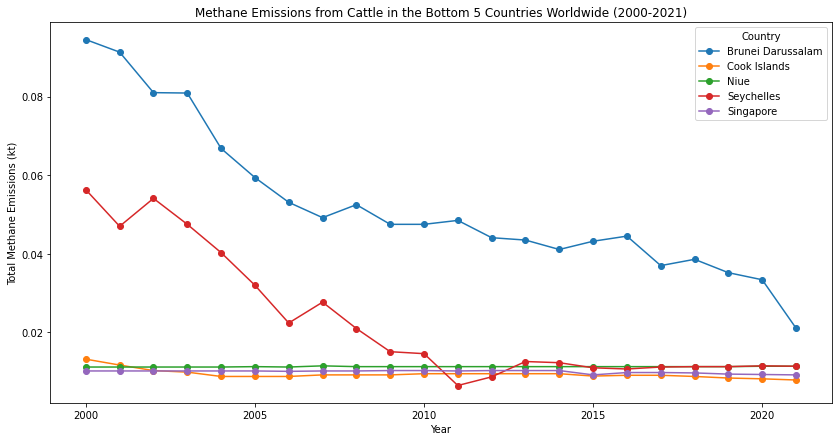

In [33]:
# @title Methane Emissions from Cattle in the Bottom 5 Countries Worldwide (2000-2021)

# Get the bottom 5 countries with the lowest total emissions
bottom_5_countries = total_emissions_by_country.nsmallest(5).index

# Filter the DataFrame for these bottom 5 countries
df_bottom_5 = df[df['Area'].isin(bottom_5_countries)]

# Group by Country and Year
emissions_by_country_year = df_bottom_5.groupby(['Area', 'Year'])['Value'].sum().unstack('Area')

# Plot line charts for the bottom 5 countries
plt.figure(figsize=(14, 7))
for country in emissions_by_country_year.columns:
    plt.plot(emissions_by_country_year.index, emissions_by_country_year[country], marker='o', linestyle='-', label=country)

plt.xlabel('Year')
plt.ylabel('Total Methane Emissions (kt)')
title = 'Methane Emissions from Cattle in the Bottom 5 Countries Worldwide (2000-2021)'
plt.title(title)
plt.legend(title='Country')
plt.show()

# Save the plot to the visualization folder
save_plot(title)

In [51]:
# Function to create the plot with a dropdown for selecting top/bottom countries
def plot_emissions_with_dropdown(df, n=5):
    # Calculate total emissions by country
    total_emissions_by_country = df.groupby('Area')['Value'].sum()

    # Create traces for top and bottom countries
    top_countries = total_emissions_by_country.nlargest(n).index
    bottom_countries = total_emissions_by_country.nsmallest(n).index

    # Filter the DataFrame for the selected countries
    df_top = df[df['Area'].isin(top_countries)]
    df_bottom = df[df['Area'].isin(bottom_countries)]

    # Initialize the figure
    fig = go.Figure()

    # Add traces for top countries
    for country in top_countries:
        country_data = df_top[df_top['Area'] == country]
        fig.add_trace(go.Scatter(x=country_data['Year'], y=country_data['Value'],
                                 mode='lines+markers', name=country))

    # Add traces for bottom countries
    for country in bottom_countries:
        country_data = df_bottom[df_bottom['Area'] == country]
        fig.add_trace(go.Scatter(x=country_data['Year'], y=country_data['Value'],
                                 mode='lines+markers', name=country, visible='legendonly'))

    # Create a dropdown menu for selecting top/bottom
    fig.update_layout(
        updatemenus=[
            {
                'buttons': [
                    {
                        'label': 'Top 5 Countries',
                        'method': 'update',
                        'args': [
                            {'visible': [True] * n + [False] * n},  # Only show top countries
                            {'title': 'Methane Emissions from Cattle for Top 5 Countries Worldwide (2000-2021)'},
                        ],
                    },
                    {
                        'label': 'Bottom 5 Countries',
                        'method': 'update',
                        'args': [
                            {'visible': [False] * n + [True] * n},  # Only show bottom countries
                            {'title': 'Methane Emissions from Cattle for Bottom 5 Countries Worldwide (2000-2021)'},
                        ],
                    },
                ],
                'direction': 'down',
                'showactive': True,
                'x': 0.98,
                'xanchor': 'left',
                'y': 1.28,
                'yanchor': 'top'
            }
        ]
    )

    # Update layout for better readability
    fig.update_layout(xaxis_title='Year',
                      yaxis_title='Total Methane Emissions (kt)',
                      legend_title_text='Country',
                      template='plotly_white',
                      title='Methane Emissions from Cattle Worldwide (2000-2021)')

    # Show the plot
    fig.show()

# plot for n=5 countries
plot_emissions_with_dropdown(df, n=5)

## Exploring Top 10 Countries per continent

Plot saved to visualization\Livestock_Methane_Emmission_Distribution_for_Top_10_Countries_in_Asia__2000_2021_.jpg


C:\Users\user\AppData\Local\Temp\ipykernel_23336\3517807206.py:37: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Plot saved to visualization\Livestock_Methane_Emmission_Distribution_for_Top_10_Countries_in_Europe__2000_2021_.jpg


C:\Users\user\AppData\Local\Temp\ipykernel_23336\3517807206.py:37: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Plot saved to visualization\Livestock_Methane_Emmission_Distribution_for_Top_10_Countries_in_Africa__2000_2021_.jpg


C:\Users\user\AppData\Local\Temp\ipykernel_23336\3517807206.py:37: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Plot saved to visualization\Livestock_Methane_Emmission_Distribution_for_Top_10_Countries_in_North_America__2000_2021_.jpg


C:\Users\user\AppData\Local\Temp\ipykernel_23336\3517807206.py:37: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Plot saved to visualization\Livestock_Methane_Emmission_Distribution_for_Top_10_Countries_in_South_America__2000_2021_.jpg


C:\Users\user\AppData\Local\Temp\ipykernel_23336\3517807206.py:37: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Plot saved to visualization\Livestock_Methane_Emmission_Distribution_for_Top_10_Countries_in_Oceania__2000_2021_.jpg


C:\Users\user\AppData\Local\Temp\ipykernel_23336\3517807206.py:37: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



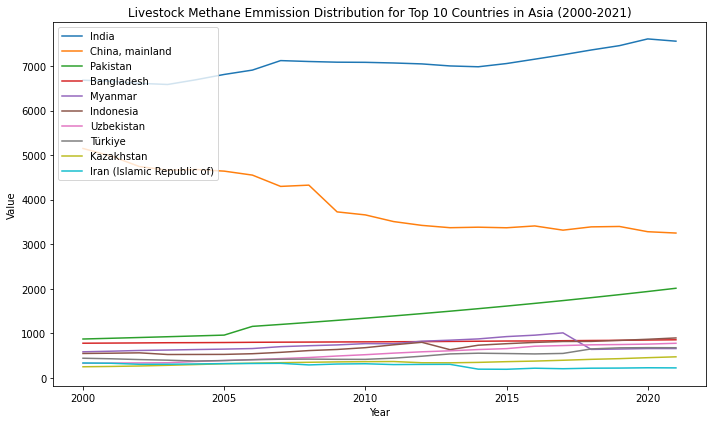

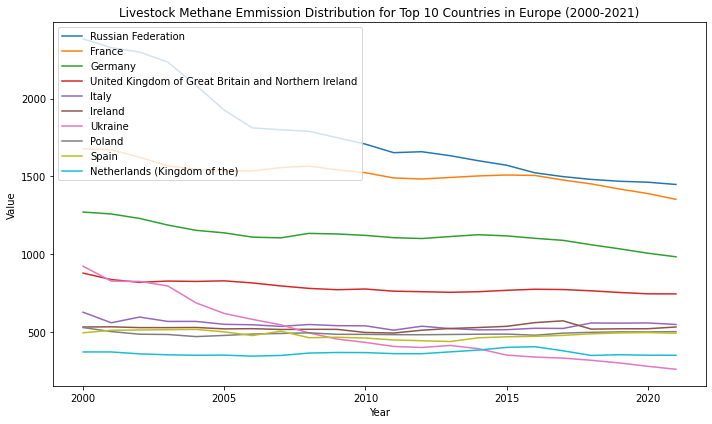

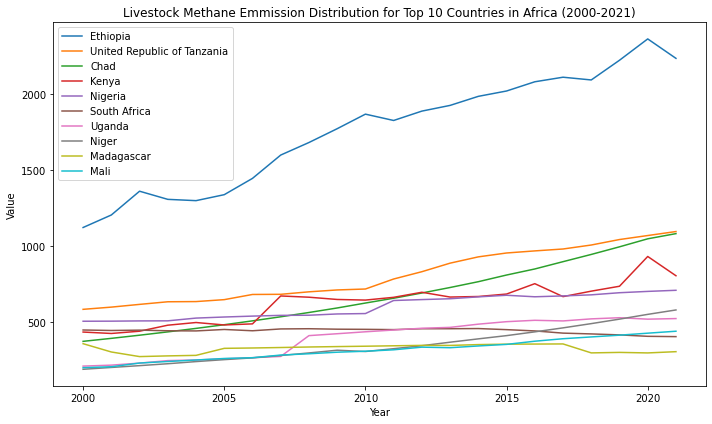

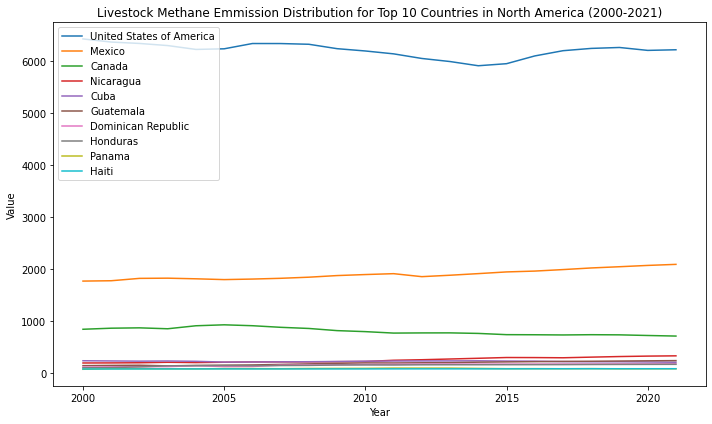

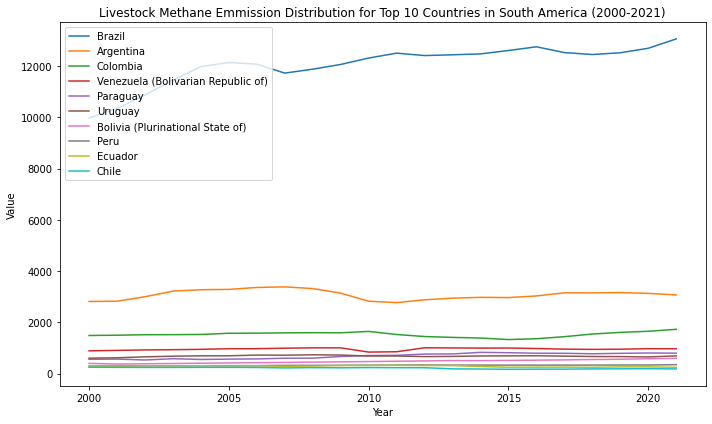

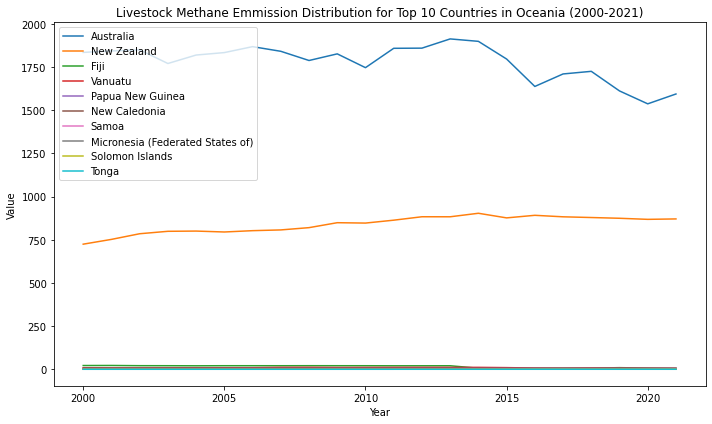

In [52]:
# Group by Continent, Area, and Year, and average the 'Value'
grouped = df.groupby(['Continent', 'Area', 'Year'])['Value'].sum().reset_index()

# Find the top 10 countries per continent based on total Value
top_countries_per_continent = grouped.groupby(['Continent', 'Area'])['Value'].sum().reset_index()
top_10_countries = top_countries_per_continent.groupby('Continent').apply(lambda x: x.nlargest(10, 'Value')).reset_index(drop=True)

# Get unique continents
continents = df['Continent'].unique()

# Plot the trend for top 10 countries per continent
for continent in continents:
    plt.figure(figsize=(10, 6))

    # Get top 10 countries for each continent
    top_countries = top_10_countries[top_10_countries['Continent'] == continent]['Area'].values

    # Filter the dataset to only include top countries
    continent_data = grouped[(grouped['Continent'] == continent) & (grouped['Area'].isin(top_countries))]

    # Plot lines for each country
    for country in top_countries:
        country_data = continent_data[continent_data['Area'] == country]
        plt.plot(country_data['Year'], country_data['Value'], label=country)

    title = f'Livestock Methane Emmission Distribution for Top 10 Countries in {continent} (2000-2021)'
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.legend(loc='upper left')
    
    # Save the plot to the visualization folder
    save_plot(title)

    # Show the plot for the current continent
    plt.tight_layout()
    plt.show()

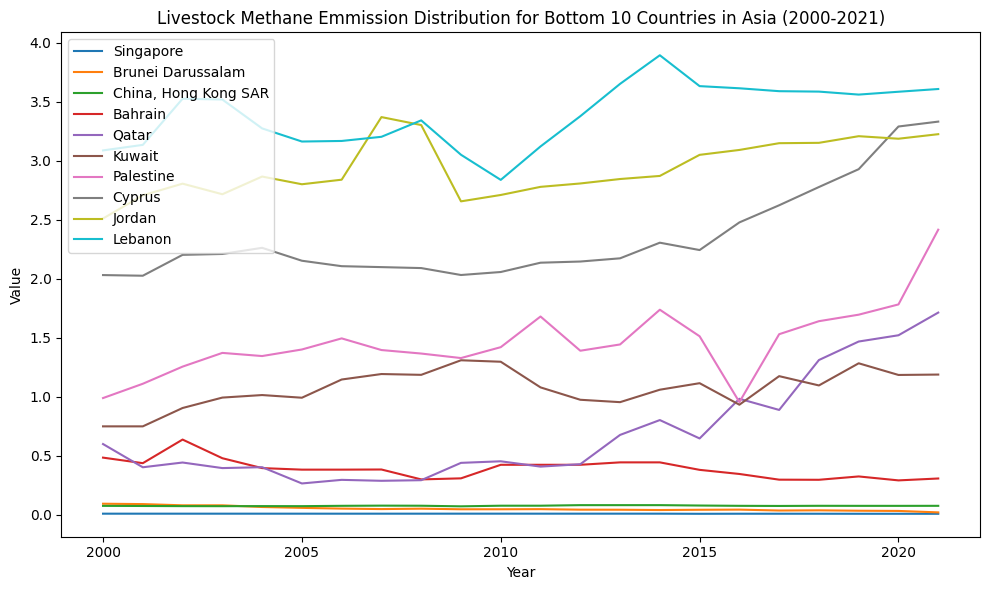

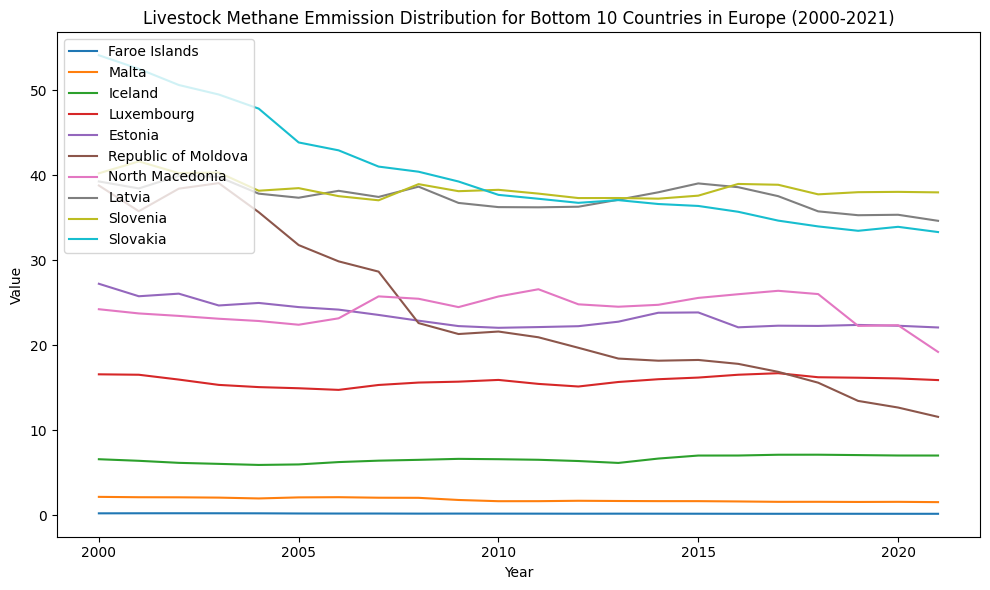

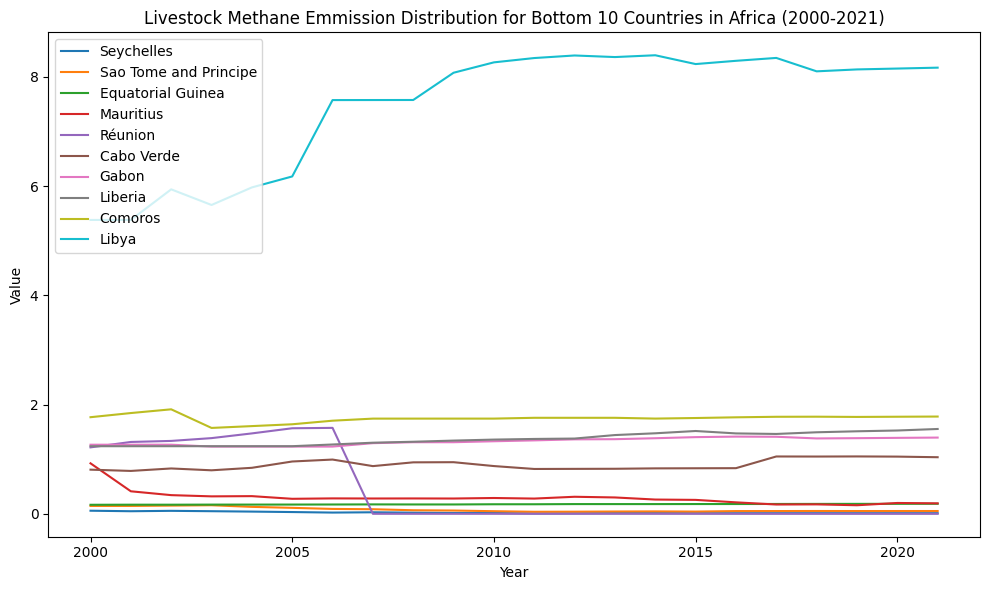

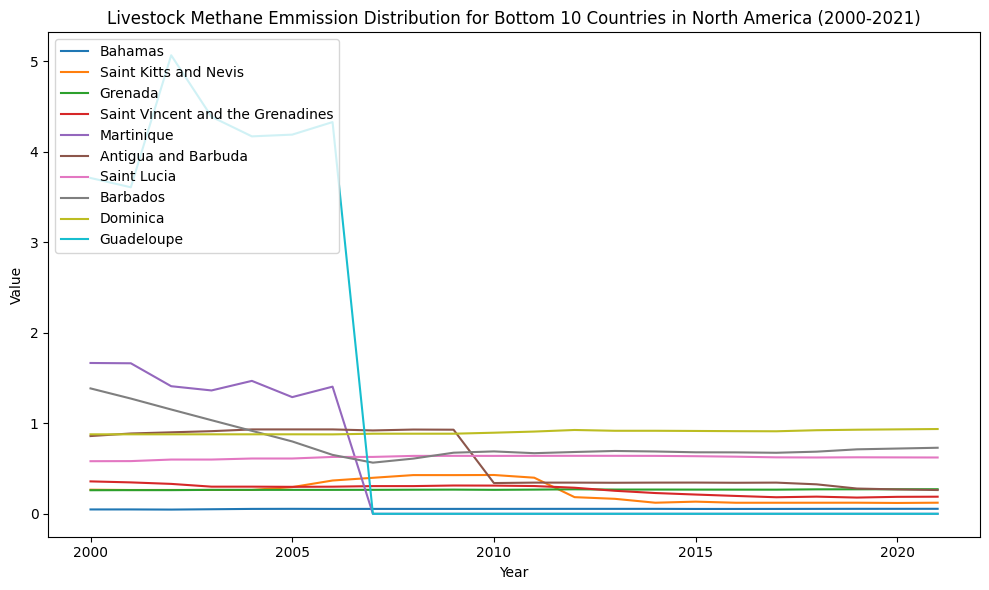

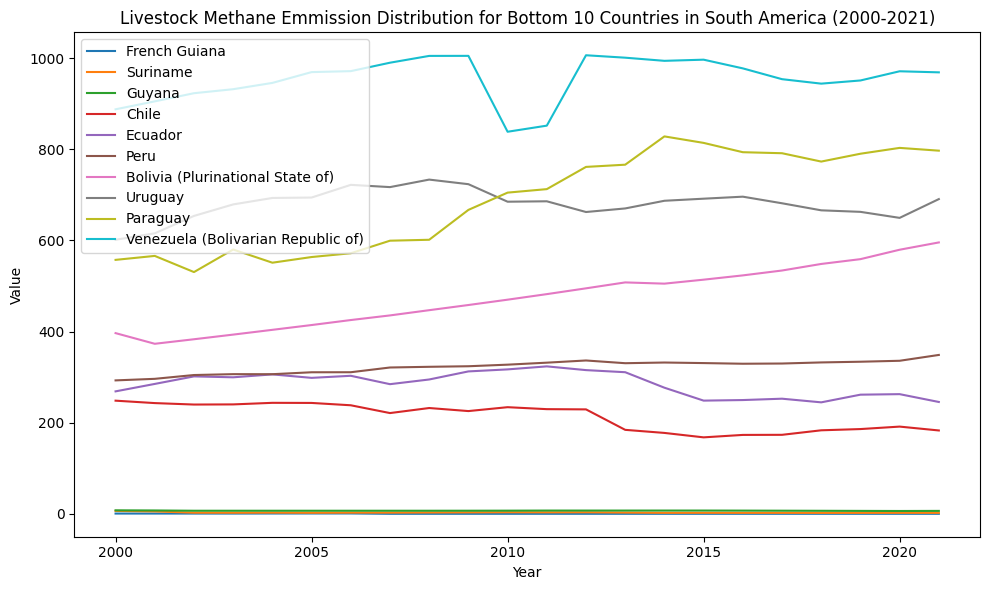

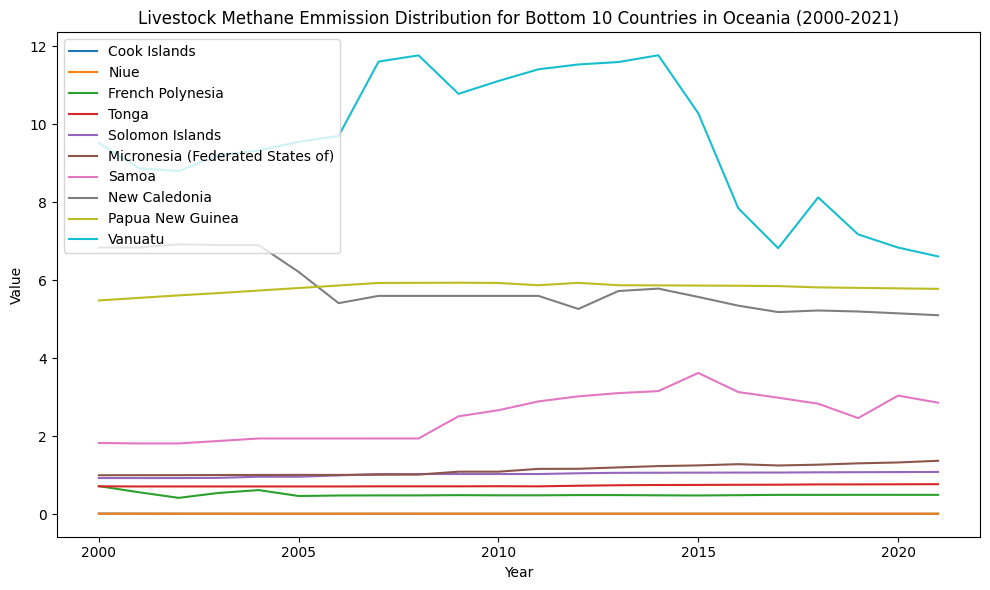

In [ ]:
# Group by Continent, Area, and Year, and average the 'Value'
grouped = df.groupby(['Continent', 'Area', 'Year'])['Value'].sum().reset_index()

# Find the bottom 10 countries per continent based on total Value
bottom_countries_per_continent = grouped.groupby(['Continent', 'Area'])['Value'].sum().reset_index()
bottom_10_countries = bottom_countries_per_continent.groupby('Continent').apply(lambda x: x.nsmallest(10, 'Value')).reset_index(drop=True)

# Get unique continents
continents = df['Continent'].unique()

# Plot the trend for bottom 10 countries per continent
for continent in continents:
    plt.figure(figsize=(10, 6))

    # Get bottom 10 countries for each continent
    bottom_countries = bottom_10_countries[bottom_10_countries['Continent'] == continent]['Area'].values

    # Filter the dataset to only include bottom countries
    continent_data = grouped[(grouped['Continent'] == continent) & (grouped['Area'].isin(bottom_countries))]

    # Plot lines for each country
    for country in bottom_countries:
        country_data = continent_data[continent_data['Area'] == country]
        plt.plot(country_data['Year'], country_data['Value'], label=country)

    plt.title(f'Livestock Methane Emmission Distribution for Bottom 10 Countries in {continent} (2000-2021)')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.legend(loc='upper left')

    # Show the plot for the current continent
    plt.tight_layout()
    plt.show()


In [55]:
# Group by Continent, Area, and Year, and average the 'Value'
grouped = df.groupby(['Continent', 'Area', 'Year'])['Value'].mean().reset_index()

# Find the top 10 countries per continent based on total Value
top_countries_per_continent = grouped.groupby(['Continent', 'Area'])['Value'].mean().reset_index()
top_10_countries = top_countries_per_continent.groupby('Continent').apply(lambda x: x.nlargest(10, 'Value')).reset_index(drop=True)

# Create a figure with dropdown
fig = go.Figure()

# Create dropdown options for each continent
for continent in top_10_countries['Continent'].unique():
    top_countries = top_10_countries[top_10_countries['Continent'] == continent]['Area'].values
    continent_data = grouped[(grouped['Continent'] == continent) & (grouped['Area'].isin(top_countries))]

    # Add trace for each country in the selected continent
    for country in top_countries:
        country_data = continent_data[continent_data['Area'] == country]
        fig.add_trace(go.Scatter(x=country_data['Year'], y=country_data['Value'], mode='lines+markers',
                                 name=f'{country} - {continent}',
                                 visible=False))  # Initially set all traces to invisible

# Add visibility toggle through dropdown buttons
buttons = []
for i, continent in enumerate(top_10_countries['Continent'].unique()):
    visible = [False] * len(fig.data)
    start_idx = i * 10  # Each continent has 10 countries
    visible[start_idx:start_idx + 10] = [True] * 10  # Show only the countries for the selected continent

    buttons.append(dict(label=continent,
                        method="update",
                        args=[{"visible": visible},
                              {"title": f"Top 10 Countries' Methane Emission in {continent} (2000-2021)"}]))

# Update layout with dropdown menu
fig.update_layout(
    updatemenus=[dict(active=0,
                      buttons=buttons,
                      x=0.95, y=1.28,  # Position the dropdown
                      xanchor='left', yanchor='top')],
    title="Select a Continent to View Top 10 Countries' Methane Emissions",
    xaxis_title="Year",
    yaxis_title="Methane Emission Value (kt)",
    template="plotly_white"
)

# Make the first continent (default) visible
for i in range(10):
    fig.data[i].visible = True

# Show the interactive plot
fig.show()

In [61]:
#  @title To obtain top 1 and low 1 country per continent

# Group by Continent, Area, and Year, and calculate the total emission ('Value')
grouped = df.groupby(['Continent', 'Area', 'Year'])['Value'].mean().reset_index()

country_per_continent = grouped.groupby(['Continent', 'Area'])['Value'].mean().reset_index()

# Get the top country for each continent (adjusting to select one top country)
top_1_country = country_per_continent.groupby('Continent').apply(lambda x: x.nlargest(1, 'Value')).reset_index(drop=True)

# Get the low country for each continent (adjusting to select one low country)
low_1_country = country_per_continent.groupby('Continent').apply(lambda x: x.nsmallest(1, 'Value')).reset_index(drop=True)

# Display the top 1 country with their continent
print(top_1_country[['Continent', 'Area', 'Value']])

print('\n')

# Print the low 10 country with their continent
# print(low_1_country[['Continent', 'Area', 'Value']])

       Continent                      Area         Value
0         Africa                  Ethiopia   1761.821245
1           Asia                     India   7042.418559
2         Europe        Russian Federation   1777.527877
3  North America  United States of America   6207.610786
4        Oceania                 Australia   1779.620836
5  South America                    Brazil  12055.168623




In [62]:
# @title Top Emission Country per Continent

# Plot the data using Plotly Express
fig = px.bar(top_1_country, x='Area', y='Value', color='Continent',
             title='Top Emission Country per Continent',
             labels={'Value': 'Emission Value (kt)', 'Area': 'Country'},
             hover_data=['Continent'])

# Show the plot
fig.show()

In [65]:
# @title Low Emission Countries per Continent

# Plot the data using Plotly Express
fig = px.bar(low_1_country, x='Area', y='Value', color='Continent',
             title='Smallest Emission Country per Continent',
             labels={'Value': 'Emission Value (kt)', 'Area': 'Country'},
             hover_data=['Continent'])

# Show the plot
fig.show()

In [66]:
# List only the country per continent
top_country_list = top_1_country['Area'].tolist()
low_country_list = low_1_country['Area'].tolist()

# Display the list of top country
print("Top country for each continent: ", top_country_list)
print("Bottom country for each continent: ", low_country_list)

Top country for each continent:  ['Ethiopia', 'India', 'Russian Federation', 'United States of America', 'Australia', 'Brazil']
Bottom country for each continent:  ['Seychelles', 'Singapore', 'Faroe Islands', 'Bahamas', 'Cook Islands', 'French Guiana']


## **The African Continent**

In [67]:
africa_data = df[df['Continent'] == 'Africa']
africa_data['Area'].unique()

array(['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
       'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic',
       'Chad', 'Comoros', 'Congo', "Côte d'Ivoire",
       'Democratic Republic of the Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon',
       'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho',
       'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania',
       'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger',
       'Nigeria', 'Réunion', 'Rwanda', 'Sao Tome and Principe', 'Senegal',
       'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'Togo',
       'Tunisia', 'Uganda', 'United Republic of Tanzania', 'Zambia',
       'Zimbabwe'], dtype=object)

There are 53 countries recorded for Africa.

[**Click to explore Regions in Africa**](https://www.worldatlas.com/geography/regions-of-africa.html)

In [68]:
# map countries into regions using the World Atlas (link above)
east = ['Burundi', 'Comoros', 'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 'Madagascar', 'Malawi', 'Mauritius', 'Mozambique', 'Réunion',
        'Rwanda', 'Seychelles', 'Somalia', 'Uganda', 'United Republic of Tanzania', 'Zambia']
south = ['Botswana', 'Eswatini', 'Lesotho', 'Namibia', 'South Africa', 'Zimbabwe']
north = ['Algeria', 'Egypt', 'Libya', 'Morocco', 'Tunisia']
west = ['Benin', 'Burkina Faso', 'Cabo Verde', "Côte d'Ivoire", 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Liberia', 'Mali', 'Mauritania',
        'Niger', 'Nigeria', 'Senegal', 'Sierra Leone', 'Togo']
central = ['Angola', 'Cameroon', 'Central African Republic', 'Chad', 'Congo', 'Democratic Republic of the Congo', 'Equatorial Guinea', 'Gabon', 'Sao Tome and Principe']

In [76]:
# Create a dictionary of regions and countries
regions = {
    'East Africa': east,
    'Southern Africa': south,
    'North Africa': north,
    'West Africa': west,
    'Central Africa': central
}

# Create a function to map countries to regions
def get_region(country):
    for region, countries in regions.items():
        if country in countries:
            return region
    return None

# Create a new column 'Region' using .loc to avoid the warning
africa_data.loc[:, 'Region'] = africa_data['Area'].apply(get_region)

# Print the updated DataFrame
print(africa_data.head())

       Area  Year    Value Continent Area Code (ISO3)        Region
44  Algeria  2000  64.5483    Africa              DZA  North Africa
45  Algeria  2001  66.7373    Africa              DZA  North Africa
46  Algeria  2002  61.4546    Africa              DZA  North Africa
47  Algeria  2003  63.3324    Africa              DZA  North Africa
48  Algeria  2004  66.6834    Africa              DZA  North Africa


C:\Users\user\AppData\Local\Temp\ipykernel_23336\3335482440.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\user\AppData\Local\Temp\ipykernel_23336\1324111392.py:27: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



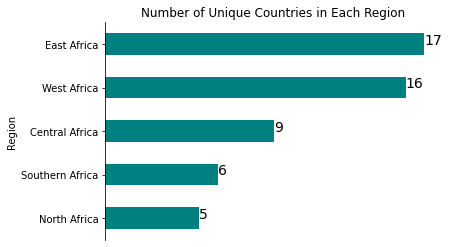

In [70]:
# @title Number of Unique Countries in Each Region

# Group by Region and count unique areas (countries), sorted in descending order
Region_area_counts = africa_data.groupby('Region')['Area'].nunique().sort_values(ascending=True)

# Plotting the horizontal bar chart
# plt.figure(figsize=(10, 6))
bars = Region_area_counts.plot(kind='barh', color='teal')

# Add labels at the end of each bar
for index, value in enumerate(Region_area_counts):
    plt.text(value, index, str(value), va='baseline', ha='left', fontsize=14, color='black')

# Remove the top, right, and bottom border (spines)
bars.spines['top'].set_visible(False)
bars.spines['right'].set_visible(False)
bars.spines['bottom'].set_visible(False)

# Remove the x-axis ticks
plt.xticks([])

# Add titles and labels
plt.title('Number of Unique Countries in Each Region')
plt.ylabel('Region')

# Display the plot
plt.show()

In [71]:
#Inspect summed statistics of grouped countries as region
africa_data.groupby('Region')['Value'].sum()

Region
Central Africa     26151.9158
East Africa        98082.3858
North Africa        8534.9693
Southern Africa    18225.6171
West Africa        47501.9195
Name: Value, dtype: float64

C:\Users\user\AppData\Local\Temp\ipykernel_23336\1286956925.py:10: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Plot saved to visualization\Regional_Livestock_Methane_Emmission_Distribution_in_Africa__2000_2021_.jpg


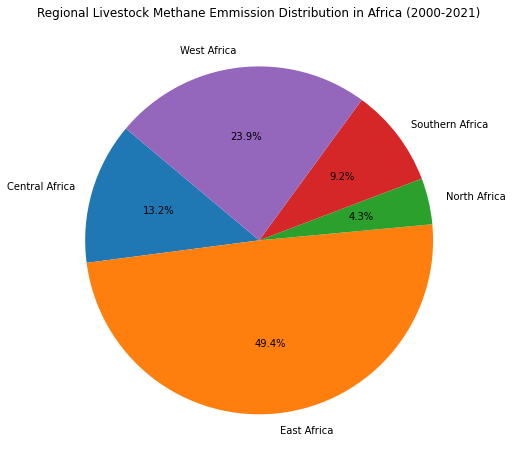

In [77]:
# @title Regional Livestock Methane Emmission Distribution in Africa (2000-2021)

# Group by 'Region' and sum the 'Value'
region_values = africa_data.groupby('Region')['Value'].sum()
plt.figure(figsize=(8, 8))
plt.pie(region_values, labels=region_values.index, autopct='%1.1f%%', startangle=140)
title = 'Regional Livestock Methane Emmission Distribution in Africa (2000-2021)'
plt.title(title)
# plt.axis('equal')
plt.show()

save_plot(title)

In [73]:
# @title Livestock Methane Emmission Distribution for African Regions (2000-2021)

# Group by 'Region' and sum the 'Value'
region_value_sum = africa_data.groupby('Region')['Value'].sum().reset_index()

# Sort the data by 'Value' in ascending order
region_value_sum = region_value_sum.sort_values(by='Value', ascending=True)

# Create a horizontal bar chart
fig = px.bar(region_value_sum,
             x='Value',
             y='Region',
             orientation='h',  # Horizontal bars
             title='Total Methane Emissions by Region in Africa',
             labels={'Value': 'Total Methane Emissions (kt)', 'Region': 'Region'},
             text='Value')  # Add text labels

# Customize layout
fig.update_layout(
    template='plotly_white',
    xaxis=dict(showticklabels=False),  # Remove x-axis ticks
    showlegend=False
)

# Add labels to the end of each bar
fig.update_traces(textposition='outside')

# Remove the top, right, and bottom border
fig.update_layout(
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis=dict(showline=False),
    xaxis=dict(showline=False)
)

# Show the plot
fig.show()

In [74]:
#@title Average Methane Emissions from Cattle by African Region (2000-2021)

# Group the data by Region and year, and calculate the mean of the 'Value' column
emissions_by_Region_year = africa_data.groupby(['Region', 'Year'])['Value'].mean().reset_index()

# Create an empty figure
fig = go.Figure()

# Add a trace for each Region
Regions = emissions_by_Region_year['Region'].unique()
for Region in Regions:
    Region_data = emissions_by_Region_year[emissions_by_Region_year['Region'] == Region]
    fig.add_trace(go.Scatter(x=Region_data['Year'], y=Region_data['Value'], mode='lines+markers', name=Region, visible=False))

# Make only the first Region visible
fig.data[0].visible = True

# Create dropdown menu options
dropdown_buttons = []
for i, Region in enumerate(Regions):
    dropdown_buttons.append(dict(method='update',
                                 label=Region,
                                 args=[{'visible': [j == i for j in range(len(Regions))]},
                                       {'title': f'Average Methane Emissions from Cattle in {Region} (2000-2021)'}]))

# Add dropdown to the layout
fig.update_layout(
    updatemenus=[dict(active=0, buttons=dropdown_buttons, x=1.15, y=1.15)],
    title=f'Average Methane Emissions from Cattle in {Regions[0]} (2000-2021)',
    xaxis_title='Year',
    yaxis_title='Total Methane Emissions (kt)',
)

# Show the figure
fig.show()

In [75]:
# @title Top 5 Countries' Methane Emission in Africa Regions

# Group by Region, Area, and Year, and average the 'Value'
grouped = africa_data.groupby(['Region', 'Area', 'Year'])['Value'].mean().reset_index()

# Find the top 5 countries per Region based on total Value
top_countries_per_Region = grouped.groupby(['Region', 'Area'])['Value'].mean().reset_index()
top_5_countries = top_countries_per_Region.groupby('Region').apply(lambda x: x.nlargest(5, 'Value')).reset_index(drop=True)

# Create a figure with dropdown
fig = go.Figure()

# Create dropdown options for each Region
for Region in top_5_countries['Region'].unique():
    top_countries = top_5_countries[top_5_countries['Region'] == Region]['Area'].values
    Region_data = grouped[(grouped['Region'] == Region) & (grouped['Area'].isin(top_countries))]

    # Add trace for each country in the selected Region
    for country in top_countries:
        country_data = Region_data[Region_data['Area'] == country]
        fig.add_trace(go.Scatter(x=country_data['Year'], y=country_data['Value'], mode='lines+markers',
                                 name=f'{country} - {Region}',
                                 visible=False))  # Initially set all traces to invisible

# Add visibility toggle through dropdown buttons
buttons = []
for i, Region in enumerate(top_5_countries['Region'].unique()):
    visible = [False] * len(fig.data)
    start_idx = i * 5  # Each Region has 5 countries
    visible[start_idx:start_idx + 5] = [True] * 5  # Show only the countries for the selected Region

    buttons.append(dict(label=Region,
                        method="update",
                        args=[{"visible": visible},
                              {"title": f"Top 5 Countries' Methane Emission in {Region} (2000-2021)"}]))

# Update layout with dropdown menu
fig.update_layout(
    updatemenus=[dict(active=0,
                      buttons=buttons,
                      x=0.17, y=1.15,  # Position the dropdown
                      xanchor='left', yanchor='top')],
    title="Select an African Region to View Top 5 Countries' Methane Emissions",
    xaxis_title="Year",
    yaxis_title="Methane Emission Value (kt)",
    template="plotly_white"
)

# Make the first Region (default) visible
for i in range(5):
    fig.data[i].visible = True

# Show the interactive plot
fig.show()

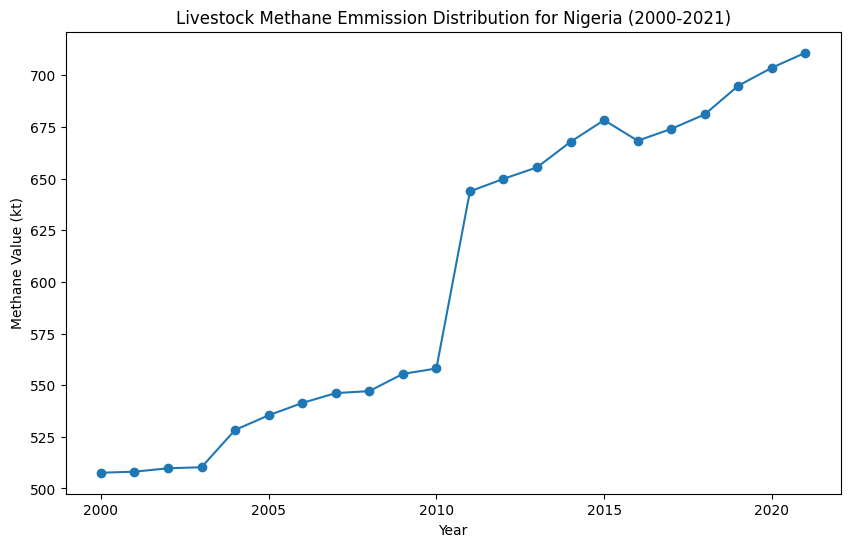

In [ ]:
# @title Livestock Methane Emmission Distribution for Nigeria (2000-2021)

plt.figure(figsize=(10, 6))
Nigeria_data = df[df['Area'] == 'Nigeria']
plt.plot(Nigeria_data['Year'], Nigeria_data['Value'], marker='o')
plt.title('Livestock Methane Emmission Distribution for Nigeria (2000-2021)')
plt.xlabel('Year')
plt.ylabel('Methane Value (kt)');

In [78]:
# Filter the data for Nigeria
Nigeria_data = df[df['Area'] == 'Nigeria']

# Plot the line chart using Plotly Express
fig = px.line(Nigeria_data, x='Year', y='Value', markers=True,
              title='Livestock Methane Emission Distribution for Nigeria (2000-2021)',
              labels={'Value': 'Methane Value (kt)', 'Year': 'Year'})

# Customize layout (optional)
fig.update_layout(
    title_x=0.5,  # Center title
    xaxis_title='Year',
    yaxis_title='Methane Value (kt)',
    showlegend=False
)

# Display the plot
fig.show()

## Modeling

In [88]:
# import libraries
from prophet import Prophet

In [89]:
df.head()

,Area,Year,Value,Continent,Area Code (ISO3)
0,Afghanistan,2000,152.100,Asia,AFG
1,Afghanistan,2001,119.621,Asia,AFG
2,Afghanistan,2002,196.135,Asia,AFG
3,Afghanistan,2003,199.441,Asia,AFG
4,Afghanistan,2004,182.926,Asia,AFG


In [90]:
prophet_data = df.copy()
prophet_data['Year'] = pd.to_datetime(prophet_data['Year'], format='%Y')
prophet_data.head()

,Area,Year,Value,Continent,Area Code (ISO3)
0,Afghanistan,2000-01-01,152.100,Asia,AFG
1,Afghanistan,2001-01-01,119.621,Asia,AFG
2,Afghanistan,2002-01-01,196.135,Asia,AFG
3,Afghanistan,2003-01-01,199.441,Asia,AFG
4,Afghanistan,2004-01-01,182.926,Asia,AFG


In [91]:
# Select the country and prepare the data for Prophet
selected_country = 'Nigeria'
country_data = prophet_data[prophet_data['Area'] == selected_country]

# Prepare the DataFrame for model
model_data = country_data[['Year', 'Value']].rename(columns={'Year': 'ds', 'Value': 'y'})
model_data.head()

,ds,y
2810,2000-01-01,507.5981
2811,2001-01-01,508.1038
2812,2002-01-01,509.7452
2813,2003-01-01,510.2584
2814,2004-01-01,528.3050


18:51:59 - cmdstanpy - INFO - Chain [1] start processing
18:52:22 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\AppData\Local\Temp\ipykernel_23336\482251924.py:17: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



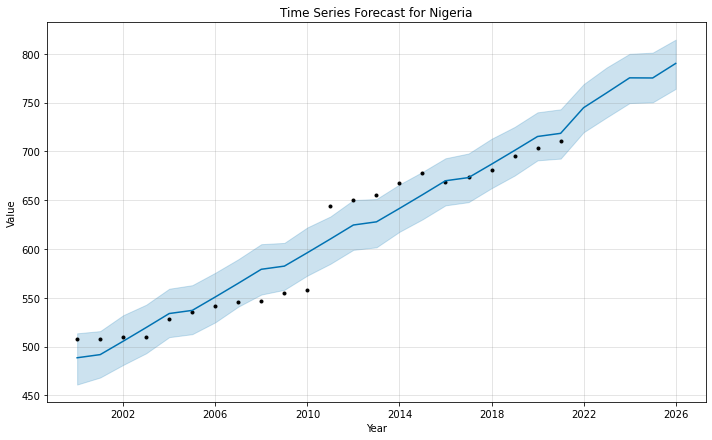

In [92]:
# Fit the Prophet model
model = Prophet()
model.fit(model_data)

# Create future dates for prediction of 5 years ahead with a yearly frequency
future = model.make_future_dataframe(periods=5, freq= 'Y')


# predict the future values
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title(f'Time Series Forecast for {selected_country}')
plt.xlabel('Year')
plt.ylabel('Value')
plt.show()

<Axes: xlabel='ds'>

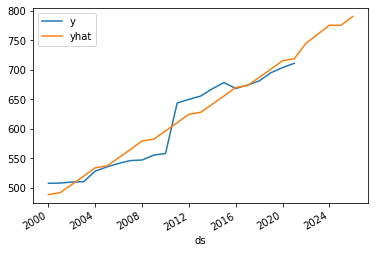

In [93]:
# plot of original and forecast methane emission value line chart
pd.concat([model_data.set_index('ds')['y'],
           forecast.set_index('ds')['yhat']],axis=1).plot()

Creating Prophet model for Ethiopia


18:52:37 - cmdstanpy - INFO - Chain [1] start processing
18:52:38 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\AppData\Local\Temp\ipykernel_23336\4229310150.py:35: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Creating Prophet model for India


18:52:44 - cmdstanpy - INFO - Chain [1] start processing
18:52:45 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\AppData\Local\Temp\ipykernel_23336\4229310150.py:35: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Creating Prophet model for Russian Federation


18:52:49 - cmdstanpy - INFO - Chain [1] start processing
18:52:50 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\AppData\Local\Temp\ipykernel_23336\4229310150.py:35: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Creating Prophet model for United States of America


18:52:54 - cmdstanpy - INFO - Chain [1] start processing
18:52:55 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\AppData\Local\Temp\ipykernel_23336\4229310150.py:35: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Creating Prophet model for Australia


18:53:00 - cmdstanpy - INFO - Chain [1] start processing
18:53:00 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\AppData\Local\Temp\ipykernel_23336\4229310150.py:35: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Creating Prophet model for Brazil


18:53:05 - cmdstanpy - INFO - Chain [1] start processing
18:53:06 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\AppData\Local\Temp\ipykernel_23336\4229310150.py:35: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Creating Prophet model for Seychelles


18:53:10 - cmdstanpy - INFO - Chain [1] start processing
18:53:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\AppData\Local\Temp\ipykernel_23336\4229310150.py:35: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Creating Prophet model for Singapore


18:53:14 - cmdstanpy - INFO - Chain [1] start processing
18:53:15 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\AppData\Local\Temp\ipykernel_23336\4229310150.py:35: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Creating Prophet model for Faroe Islands


18:53:19 - cmdstanpy - INFO - Chain [1] start processing
18:53:19 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\AppData\Local\Temp\ipykernel_23336\4229310150.py:35: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Creating Prophet model for Bahamas


18:53:23 - cmdstanpy - INFO - Chain [1] start processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\AppData\Local\Temp\ipykernel_23336\4229310150.py:35: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Creating Prophet model for Cook Islands


18:53:28 - cmdstanpy - INFO - Chain [1] start processing
18:53:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\AppData\Local\Temp\ipykernel_23336\4229310150.py:35: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



Creating Prophet model for French Guiana


18:53:33 - cmdstanpy - INFO - Chain [1] start processing
18:53:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\user\AppData\Local\Temp\ipykernel_23336\4229310150.py:35: UserWarning:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.



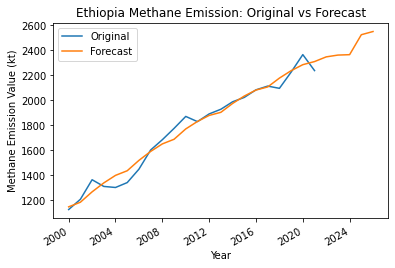

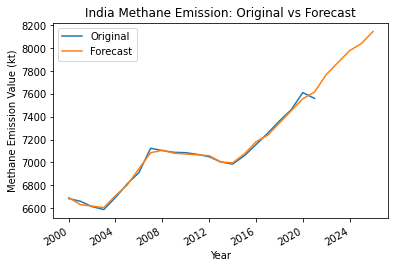

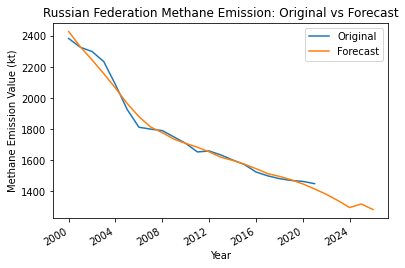

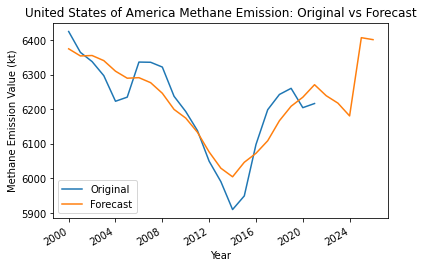

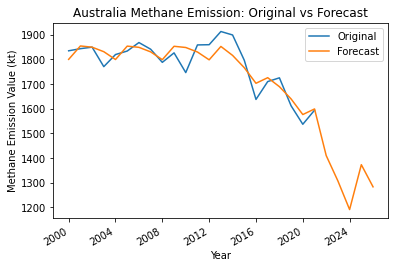

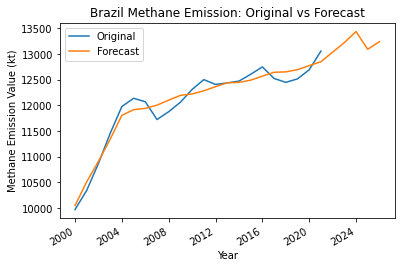

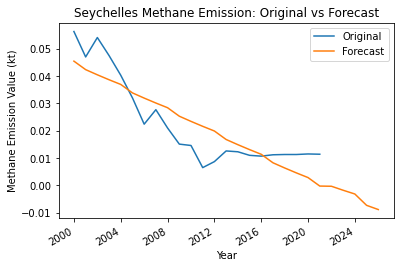

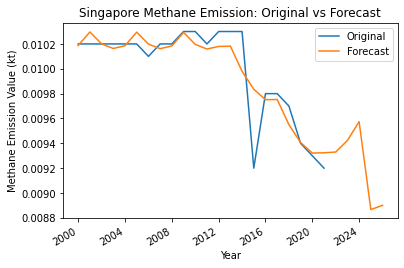

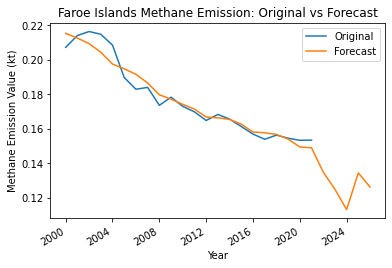

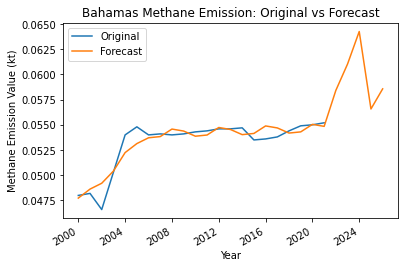

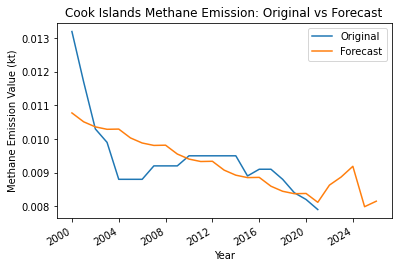

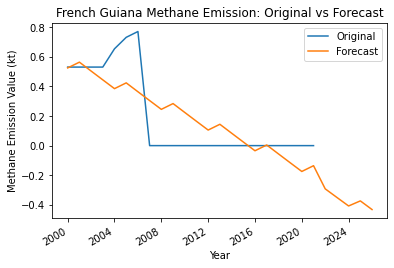

In [94]:
# Lists of countries
# top_countries_list =
# low_countries_list =


# Function to create Prophet model for each country and plot
def create_prophet_model(country, df):
    # Filter the data for the selected country
    country_data = df[df['Area'] == country]

    # Prepare the DataFrame for Prophet
    model_data = country_data[['Year', 'Value']].rename(columns={'Year': 'ds', 'Value': 'y'})

    # Initialize Prophet model
    model = Prophet()

    # Fit the model on the data
    model.fit(model_data)

    # Create a dataframe for future predictions
    future = model.make_future_dataframe(periods=5, freq='Y') # predict the next 5 years

    # Make predictions
    forecast = model.predict(future)

    # Combine actual and predicted values for plotting
    combined_data = pd.concat([model_data.set_index('ds')['y'],
                               forecast.set_index('ds')['yhat']], axis=1)

    # Plot original and forecast methane emission value line chart
    combined_data.plot(title=f'{country} Methane Emission: Original vs Forecast')
    plt.xlabel('Year')
    plt.ylabel('Methane Emission Value (kt)')
    plt.legend(['Original', 'Forecast'])
    plt.show()

# Loop through top and low countries to create models and forecasts
for country in top_country_list + low_country_list:
    print(f"Creating Prophet model for {country}")
    create_prophet_model(country, prophet_data)